# RNN Model

#### Goal of This File:

##### 1. Import Libraries and Helper Functions ==> Data Sourcing and Munging ==> Utility Functions ==> Loading the Data ==> Merging all Files

##### 2. Imbalanced Data Solution ==> Glove Embedding

##### 3. Simple RNN

##### 4. Conclusion ==> Results ==> Tensorboard

## 1. Import Libraries, Helper Functions and Load Constants

In [1]:
!pip install pandas numpy nltk scikit-learn wordcloud seaborn gensim tensorflow imblearn xgboost matplotlib > /dev/null


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already u

True

In [3]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
GLOVE_URL = 'https://f005.backblazeb2.com/file/glove-embeddings-dims/glove.6B.100d.txt'
LIMIT = 60
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [4]:
def get_chunks(urls,limit=0,verbose = 1,base_name = "temp",file_path="",file_format='.csv',loading_chunks = True):
    #downloads all data from their url(s)
    for i,url in enumerate(urls):
        if limit:
            if i == limit:
                return
        if loading_chunks:
            file_name = base_name + str(i + 1)
        else:
            file_name = base_name
        #checks if file already exists
        if os.path.exists(file_path + file_name + file_format):
            print(f"{file_name} already exists.")
            continue
        if i % verbose == 0:
            print(f"Downloading {file_name}...")
        r = requests.get(url)
        with open(file_path + file_name + file_format, 'wb') as fd:
            for chunk in r.iter_content():
                #save file in the current directory of the notebook
                fd.write(chunk)

In [5]:
def get_all_file_names(base_name,limit_num):
    return [base_name + str(num) for num in range(1,limit_num + 1)]

In [6]:
def read_chunks(files,file_path = "",file_format = ".csv"):
    #reads chunks csvs and converts them to a dataframe format
    final_df = []
    for file in files:
        df = pd.read_csv(file_path + file + file_format)
        final_df.append(df)
    #function returns a list of dfs
    return final_df

In [7]:
def group_up_chunks(dfs):
    #adds up all dataframes together
    return pd.concat(dfs)

In [8]:
def check_no_missing_data(shape_loaded,shape_actual):
    actual_shape_loaded = (shape_loaded / shape_actual) * 100
    return actual_shape_loaded

In [ ]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
            
    return word_to_vec_map

#### 1.1.2 Loading The Data

In [9]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.
chunk_7 already exists.
chunk_8 already exists.
chunk_9 already exists.
chunk_10 already exists.
chunk_11 already exists.
chunk_12 already exists.
chunk_13 already exists.
chunk_14 already exists.
chunk_15 already exists.
chunk_16 already exists.
chunk_17 already exists.
chunk_18 already exists.
chunk_19 already exists.
chunk_20 already exists.
chunk_21 already exists.
chunk_22 already exists.
chunk_23 already exists.
chunk_24 already exists.
chunk_25 already exists.
chunk_26 already exists.
chunk_27 already exists.
chunk_28 already exists.
chunk_29 already exists.
chunk_30 already exists.
chunk_31 already exists.
chunk_32 already exists.
chunk_33 already exists.
chunk_34 already exists.
chunk_35 already exists.
chunk_36 already exists.
chunk_37 already exists.
chunk_38 already exists.
chunk_39 already exists.
chunk_40 already exists.
chunk_41 

#### 1.1.3 Merging all Individual Files

In [10]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [11]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [12]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [13]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [14]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [15]:
review_data = df[['text', 'stars']].copy()

In [16]:
review_data

,text,stars
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
116480,late addition service iccu apple pay iccu debi...,5.0
116481,spot offer great affordable east weekend paddl...,5.0
116482,home depot need get lot demential lumber seem ...,4.0
116483,m feel like ignore caloriecounting indulge fla...,5.0


In [17]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [18]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [19]:
review_data

,full_review_text,star_rating
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
6990275,late addition service iccu apple pay iccu debi...,5.0
6990276,spot offer great affordable east weekend paddl...,5.0
6990277,home depot need get lot demential lumber seem ...,4.0
6990278,m feel like ignore caloriecounting indulge fla...,5.0


In [20]:
review_data.isnull().sum()

full_review_text    44
star_rating          0
dtype: int64

In [21]:
review_data.dropna()

,full_review_text,star_rating
0,decide eat aware go take 2 hour begin end try ...,3.0
1,ve take lot spin class year nothing compare cl...,5.0
2,family diner buffet eclectic assortment large ...,3.0
3,wow yummy different delicious favorite lamb cu...,5.0
4,cute interior owner give u tour upcoming patio...,4.0
...,...,...
6990275,late addition service iccu apple pay iccu debi...,5.0
6990276,spot offer great affordable east weekend paddl...,5.0
6990277,home depot need get lot demential lumber seem ...,4.0
6990278,m feel like ignore caloriecounting indulge fla...,5.0


## 2. Imbalanced Data Solution

In [22]:
X = review_data['full_review_text']
y = review_data['star_rating']

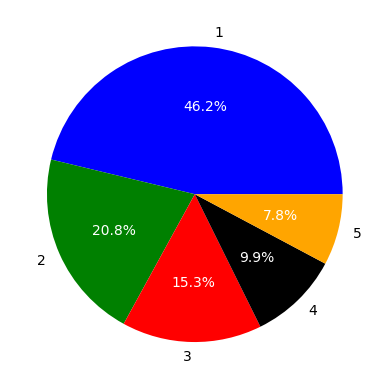

In [23]:
visualize_ratings_pie(y,1,5)

In [24]:
X = pd.Series([str(text) for text in X])

In [25]:
y = [label - 1 for label in y]

### 2.1 Class Weights

In [26]:
class_weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=y)

### 2.2 GloVe + Hyperparamters

In [28]:
if not os.path.exists('../glove_files'):
    os.mkdir('../glove_files')

In [29]:
if not os.path.exists('../glove_files/glove.6B.100d.txt'):
    print("Downloading GloVe File...")
    r = requests.get(GLOVE_URL)
    with open("../glove_files/glove.6B.100d.txt", 'wb') as fd:
        for data in r.iter_content():
            #save file in the current directory of the notebook
            fd.write(data)

In [30]:
UNIQUE_WORDS = set(' '.join(X).split())

##### Hyperparameters

In [ ]:
VOCAB_SIZE = len(UNIQUE_WORDS)
EMBEDDING_DIM = 100
MAX_TEXT_LEN = 200
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = "<OOV>"
BATCH_SIZE = 64
EPOCHS = 15

##### ==> here is a quick explaination of how the dataset will be split using a smaller sample example.
##### ==> dataset => 100
##### ==> train_set => tr_s (example: 80)
##### ==> valid_set => vs (example: 10)
##### ==> test_set => te_s (example: 10)
##### ==> t = tr_s (80) + vs (10)
##### ==> train_set = x[:80]
##### ==> valid_set = x[80:t]
##### ==> test_set = x[t:] why t? because => vs = ts

##### use this guideline if you are confused about how the train-validation-test split was done. Also, this is a future guide for me as well in case I forget.

* train_set_size = 6,990,280 * 0.8 = 5,592,224
* valid_set_size = 6,990,280 * 0.1 = 699,028
* train_plus_valid = 5,592,224 + 699,028 = 6,291,252

==> To Confirm: test_size = 6,990,280 - 6,291,252 = 699,028

* train_set = [0:5,592,224]
* train_labels = [0:5,592,224]
* validation_set = [5,592,224:6,291,252] ==> 699,028
* validation_labels = [5,592,224:6,291,252] ==> 699,028
* test_set = [6,291,252,6,990,280] ==> 699,028
* test_labels = [6,291,252,6,990,280] ==> 699,028

In [31]:
TRAIN_PERCENT = 0.8
VALID_TEST_PERCENT = 0.1
TRAIN_SIZE = int(ACTUAL_DATA_SHAPE * TRAIN_PERCENT)
VALID_TEST_SIZE = int(ACTUAL_DATA_SHAPE * VALID_TEST_PERCENT)
TOTAL_TEST_SIZE = TRAIN_SIZE + VALID_TEST_SIZE
train_set = X[:TRAIN_SIZE]
train_labels = y[:TRAIN_SIZE]
validation_set = X[TRAIN_SIZE:TOTAL_TEST_SIZE]
validation_labels = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_set = X[TOTAL_TEST_SIZE:]
test_labels = y[TOTAL_TEST_SIZE:]

In [ ]:
# NOTE: THIS CELL TAKES A WHILE TO RUN, AND THERE ARE NO PICKLE FILES FOR IT.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_set)
words_to_index = tokenizer.word_index

In [33]:
# NOTE: THIS CELL TAKES A WHILE TO RUN, AND THERE ARE NO PICKLE FILES FOR IT.
train_sequences = tokenizer.texts_to_sequences(train_set)
train_set_padded = pad_sequences(train_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

valid_sequences = tokenizer.texts_to_sequences(validation_set)
valid_set_padded = pad_sequences(valid_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

test_sequences = tokenizer.texts_to_sequences(test_set)
test_set_padded = pad_sequences(test_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [34]:
train_set_padded = np.array(train_set_padded)
train_labels = np.array(train_labels)
valid_set_padded = np.array(valid_set_padded)
validation_labels = np.array(validation_labels)
test_set_padded = np.array(test_set_padded)
test_labels = np.array(test_labels)

In [36]:
word_to_vec_map = read_glove_vector('../glove_files/glove.6B.100d.txt')

In [37]:
vocab_mapping = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_mapping, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

EMBEDDING_LAYER = Embedding(input_dim=vocab_mapping,\
                            output_dim=embed_vector_len, input_length=MAX_TEXT_LEN, weights = [emb_matrix], trainable=False)

## 3. RNN

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
rnn_model = tf.keras.models.Sequential([
    EMBEDDING_LAYER,
    tf.keras.layers.SimpleRNN(60),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dense(5, activation = "softmax")
])

2023-05-03 15:23:40.175617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:23:40.183282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:23:40.183681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [39]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          100208800 
                                                                 
 simple_rnn (SimpleRNN)      (None, 60)                9660      
                                                                 
 dense (Dense)               (None, 512)               31232     
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 100,252,257
Trainable params: 43,457
Non-trainable params: 100,208,800
_________________________________________________________________


In [41]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [43]:
rnn_model.compile(optimizer=Adam(), loss = SparseCategoricalCrossentropy(), metrics=['accuracy',custom_f1_score])
rnn_model.fit(train_set_padded, train_labels,validation_data = (valid_set_padded,validation_labels),\
              batch_size=BATCH_SIZE, epochs=EPOCHS,class_weight=dict(enumerate(class_weights)),\
              callbacks=[tensorboard_callback,EarlyStopping(patience=3),ReduceLROnPlateau(factor=0.1, patience=1)])

Epoch 1/15


2023-05-03 15:23:41.291114: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4473779200 exceeds 10% of free system memory.
2023-05-03 15:23:44.387572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-03 15:23:44.426304: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xfed046a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-03 15:23:44.426330: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-03 15:23:44.429885: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-03 15:23:44.552948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-03 15:23:44.655573: I

 7346/87379 [=>............................] - ETA: 1:33:07 - loss: 1.6083 - accuracy: 0.2714 - get_f1: 7.8349

## 4. Conclusion

### 4.1 Results

### 4.2 Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit